<a href="https://colab.research.google.com/github/soucs/ac-gans/blob/main/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Image Generation using GANs
(https://youtu.be/79IvwU3G5_Q)

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 121071853.41it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76185970.96it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43081345.02it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5065282.84it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
# Defining functions
# Fnc to denormalize image, to later view it
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# View image
def view(img):
  img = img.reshape(28,28)
  img_norm = denorm(img)
  plt.imshow(img_norm, cmap='gray')
  # print('Label:', label)

# Creating dataloader to load images in batches
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

# Device configuration - move data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # cpu is only available

# Discriminator - Using simple Feedforward NN
# 28x28 image as a vector of size 784
# Output is prob of being fake img (in the range [0,1])

image_size = 784
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device); # Moving discriminator to chosen device

# Generator - FNN with 3 layers
# Input - Matrix as seed for generating img
# Ouput - vector of size 784, to be transformed to 28x28 img

latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Generator to device
G.to(device);

# Note that since the outputs of the TanH activation lie in the range [-1,1], 
# we have applied the same transformation to the images in the training dataset.

# Discriminator Training

# Binary Cross Entropy Loss Function
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

# Generator Training

# Adam optimizer
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

cpu


Saving fake_images-0000.png


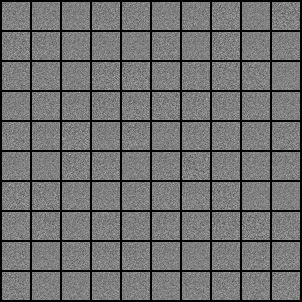

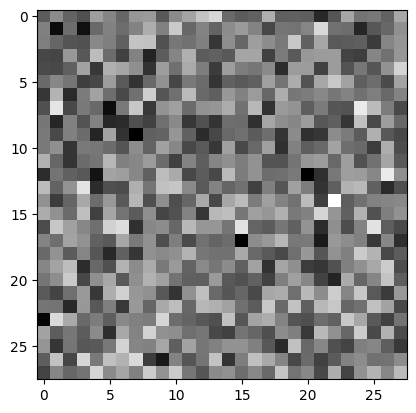

In [ ]:

# Get ouput vector, transform, denormalize, view img
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

plt.imshow(gen_imgs[0], cmap='gray');

# Directory to save intermediate outputs
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Save generated images after every epoch
from IPython.display import Image
from torchvision.utils import save_image

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


In [ ]:
# Training the model (Discriminator first, then Generator)
%%time

num_epochs = 5
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))

Epoch [0/5], Step [200/600], d_loss: 0.0629, g_loss: 3.8108, D(x): 0.99, D(G(z)): 0.05
Epoch [0/5], Step [400/600], d_loss: 0.0577, g_loss: 6.0613, D(x): 0.99, D(G(z)): 0.04
Epoch [0/5], Step [600/600], d_loss: 0.0330, g_loss: 4.9038, D(x): 0.99, D(G(z)): 0.02
Epoch [1/5], Step [200/600], d_loss: 0.0376, g_loss: 5.0109, D(x): 0.99, D(G(z)): 0.03
Epoch [1/5], Step [400/600], d_loss: 0.2005, g_loss: 4.1281, D(x): 0.95, D(G(z)): 0.12
Epoch [1/5], Step [600/600], d_loss: 0.1704, g_loss: 5.4247, D(x): 0.96, D(G(z)): 0.10
Epoch [2/5], Step [200/600], d_loss: 0.2236, g_loss: 3.9402, D(x): 0.93, D(G(z)): 0.09
Epoch [2/5], Step [400/600], d_loss: 0.1180, g_loss: 4.8092, D(x): 0.96, D(G(z)): 0.05
Epoch [2/5], Step [600/600], d_loss: 0.6795, g_loss: 3.0009, D(x): 0.88, D(G(z)): 0.36
Epoch [3/5], Step [200/600], d_loss: 0.6910, g_loss: 2.4747, D(x): 0.87, D(G(z)): 0.32
Epoch [3/5], Step [400/600], d_loss: 0.7105, g_loss: 2.1145, D(x): 0.76, D(G(z)): 0.23
Epoch [3/5], Step [600/600], d_loss: 0.9194

In [ ]:
# # Save the model checkpoints 
# torch.save(G.state_dict(), 'G.ckpt')
# torch.save(D.state_dict(), 'D.ckpt')

In [ ]:
n_classes = 2
latent_dim = 3
emb = torch.nn.Embedding(n_classes, latent_dim)

# Define some sample inputs (a batch of indices into the embedding space)
input_indices = torch.tensor([0,1,0,1])

# Pass the inputs through the embedding layer
embedded = emb(input_indices)

print(embedded)
embedded.shape

tensor([[-1.8331,  0.5550, -0.8818],
        [-0.6312, -0.6440, -0.9819],
        [-1.8331,  0.5550, -0.8818],
        [-0.6312, -0.6440, -0.9819]], grad_fn=<EmbeddingBackward0>)


torch.Size([4, 3])